In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ray import tune

#from pytorch_forecasting.models.nhits import NHiTS
from darts.models.forecasting.nhits import NHiTSModel
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality


## Data Preparation for the model

In [4]:
elect = pd.read_excel("hourly_electricity.xlsx")
elect["date"] = pd.to_datetime(elect["date"], format='%d.%m.%Y')

In [5]:
elect.head()

,date,hour,electricity
0,2017-01-01,00:00:00,27223.06
1,2017-01-01,01:00:00,25825.90
2,2017-01-01,02:00:00,24252.68
3,2017-01-01,03:00:00,22915.47
4,2017-01-01,04:00:00,22356.99


In [6]:
#create an hourly date column
elect["time"] = elect["date"].astype(str) + " " + elect["hour"].astype(str)
elect["time"] = pd.to_datetime(elect["time"])
elect.sort_values(by = "time", inplace = True)
#elect.set_index("time", inplace=True)
elect.drop(columns=["hour", "date"], inplace = True)

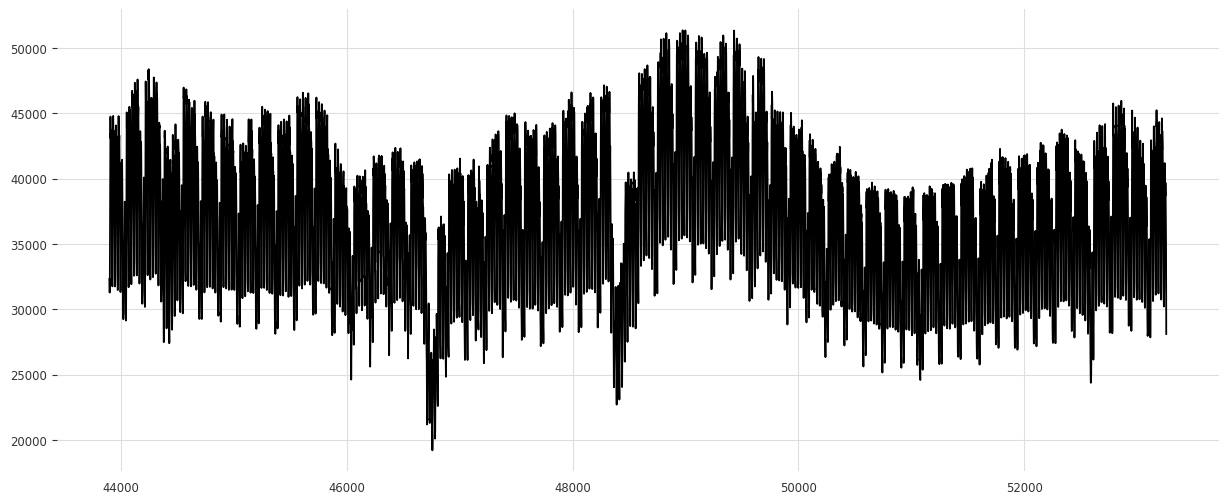

In [7]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(elect.index[-390*24:], elect["electricity"][-390*24:], label = "hourly  electricity consumption")
plt.show()

c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


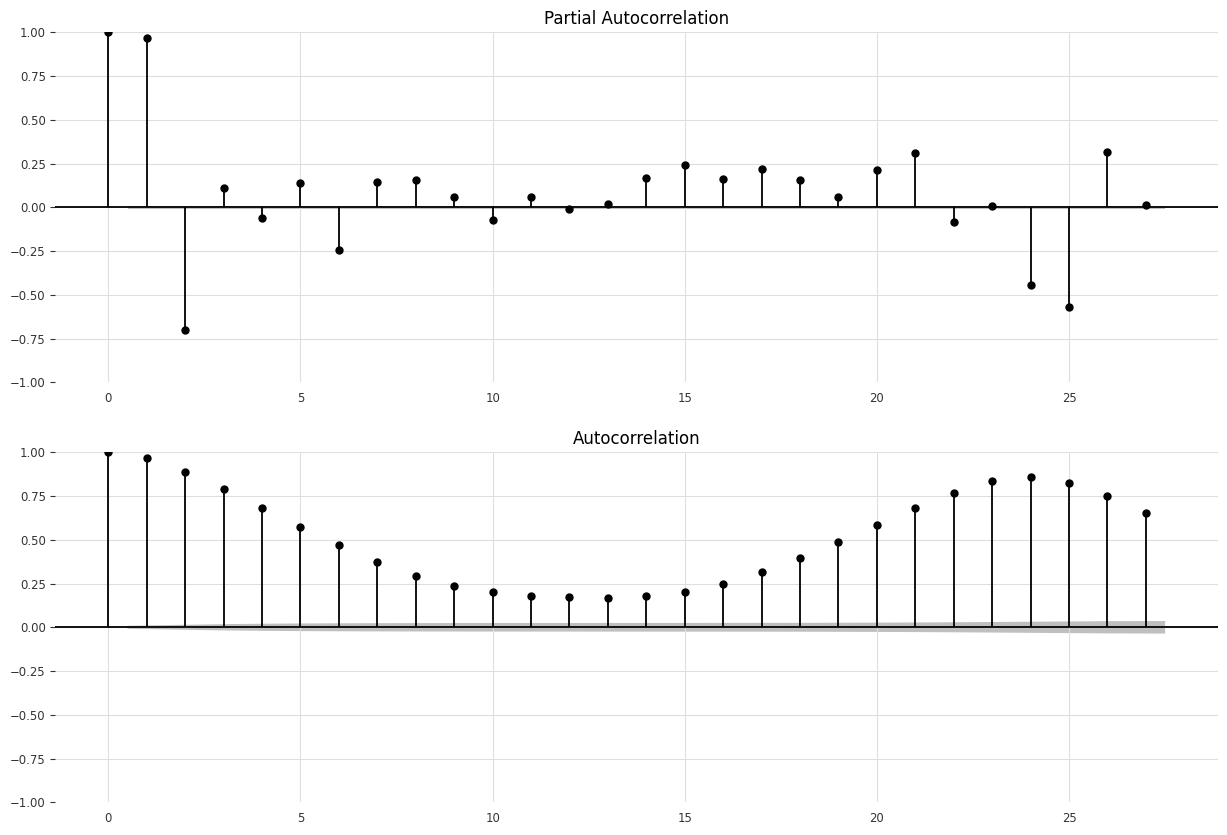

In [8]:
fig, ax = plt.subplots(2, 1, figsize = (15,10))

plot_pacf(elect["electricity"],ax = ax[0], lags = 27) # It seems that there are significant spikes until 26
plot_acf(elect["electricity"],ax = ax[1], lags = 27);

In [9]:
elect.reset_index(inplace=True)

In [27]:
elect = elect[elect["time"]>="2020-01-01"]

In [28]:
elect = elect[:-2]

In [52]:
test_size = len(elect[(elect["time"]>="2022-07-01")])

In [53]:
elect_series = TimeSeries.from_dataframe(df=elect, time_col="time", value_cols="electricity")

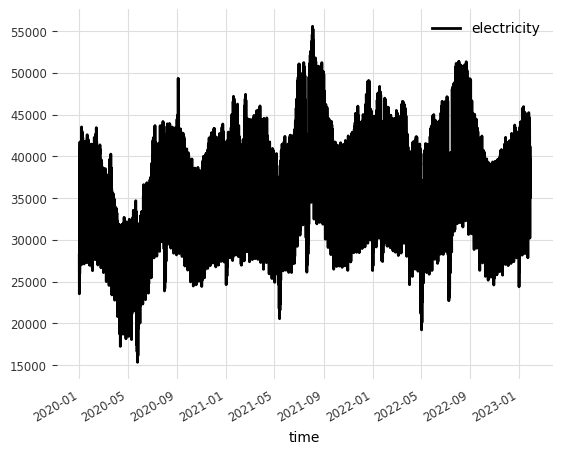

In [54]:
elect_series.plot()

In [55]:
is_daily_seasonal, daily_period = check_seasonality(elect_series, m=24, max_lag=400, alpha=0.05,)
is_weekly_seasonal, weekly_period = check_seasonality(elect_series, m=168, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 24
Weekly seasonality: True - period = 168


In [56]:
scaler = Scaler()
scaled_series = scaler.fit_transform(elect_series)

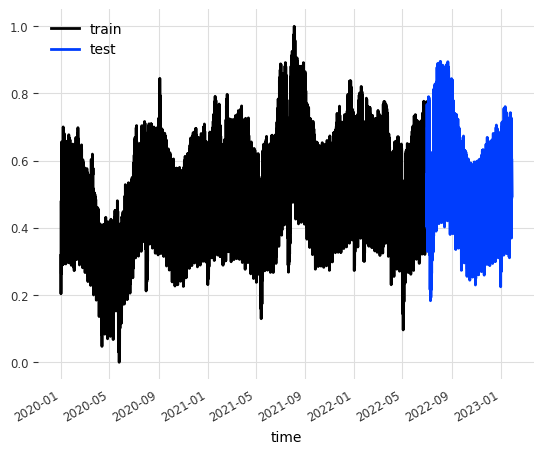

In [57]:
train, test = scaled_series[:-test_size], scaled_series[-test_size:]

train.plot(label='train')
test.plot(label='test')

In [15]:
model = NHiTSModel(input_chunk_length = 168, output_chunk_length= 480,
           num_stacks=4, num_blocks=2, num_layers=2, layer_widths=256)

In [16]:
model.fit(series=train, val_series=test, epochs=2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 3.1 M 
---------------------------------------------------
3.0 M     Trainable params
86.2 K    Non-trainable params
3.1 M     Total params
25.014    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [18]:
yhat = model.predict(n=test_size)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [20]:
pred_nhits = scaler.inverse_transform(yhat)

In [28]:
predics = pred_nhits.pd_dataframe().rename(columns={"electricity":'preds'})

In [25]:
test_real = elect[(elect["time"]>="2023-01-01")][["time", "electricity"]]

In [29]:
test_real["predis"] = np.array(predics["preds"])

In [32]:
(abs(test_real["predis"] - test_real["electricity"])*100/test_real["electricity"]).mean()

9.649531703541221

In [33]:
test_real.head()

,time,electricity,predis
52584,2023-01-01 00:00:00,28816.55,30299.464375
52585,2023-01-01 01:00:00,27589.25,28579.541955
52586,2023-01-01 02:00:00,26328.82,26562.120680
52587,2023-01-01 03:00:00,25224.40,25873.486906
52588,2023-01-01 04:00:00,24636.46,25099.002330


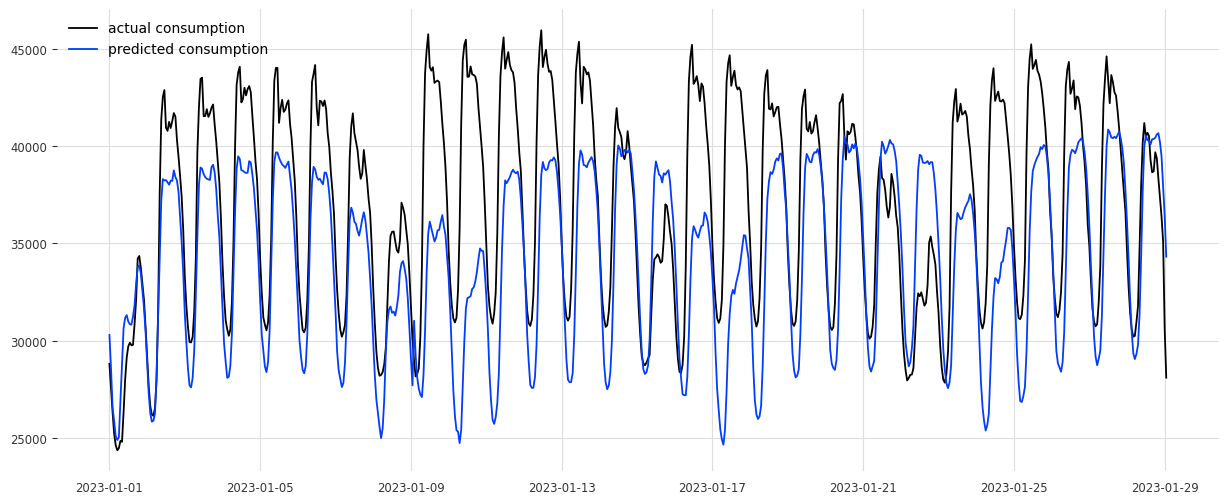

In [34]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(test_real["time"], test_real["electricity"], label = "actual consumption", color = "C0")
ax.plot(test_real["time"], test_real["predis"], label = "predicted consumption", color = "C1")
plt.legend(loc="upper left")
plt.show()

## Hyperparameter Tuning

In [44]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.models import NBEATSModel
import hyperopt
from ray.tune.search.optuna import OptunaSearch

(scheduler +1h7m36s) Error: No available node types can fulfill resource request {'GPU': 1.0, 'CPU': 8.0}. Add suitable node types to this cluster to resolve this issue.


In [ ]:
def train_model(model_args, callbacks, train, val):
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])
    # Create the model using model_args from Ray Tune
    model = NHiTSModel(
        input_chunk_length=168,
        output_chunk_length=test_size,
        n_epochs=120,
        torch_metrics=torch_metrics,
        pl_trainer_kwargs={"callbacks": callbacks, "enable_progress_bar": False},
        **model_args)

    model.fit(
        series=train,
        val_series=test,
    )


# Early stop callback
my_stopper = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",
    patience=7,
    min_delta=0.005,
    mode='min',
)

# set up ray tune callback
tune_callback = TuneReportCallback(
    {
        "loss": "val_Loss",
        "MAPE": "val_MeanAbsolutePercentageError",
    },
    on="validation_end",
)

# define the hyperparameter space
config = {
    "batch_size": tune.choice([32, 64, 128]),
    "num_blocks": tune.choice([1, 2, 3, 4, 5,6]),
    "num_stacks": tune.choice([3, 4, 5,6,7,8,9,10,11]),
    "dropout": tune.uniform(0, 0.2),
    "layer_widths": tune.choice([512, 256, 128, 64,32])
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "MAPE", "training_iteration"],
)

resources_per_trial = {"cpu": 8, "gpu": 0}

# the number of combinations to try
num_samples = 100

scheduler = ASHAScheduler(max_t=100, grace_period=3, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(
    train_model, callbacks=[my_stopper, tune_callback], train=train, val=test,
)

# optimize hyperparameters by minimizing the MAPE on the validation set
analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    # Using a metric instead of loss allows for
    # comparison between different likelihood or loss functions.
    metric="MAPE",  # any value in TuneReportCallback.
    mode="min",
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_darts",
)

print("Best hyperparameters found were: ", analysis.best_config)

(train_model pid=8480) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=8480) 2023-03-11 12:10:28,982	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=8480) Traceback (most recent call last):
(train_model pid=8480)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=8480)     self._entrypoint()
(train_model pid=8480)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=8480)     return self._trainable_func(
(train_model pid=8480)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=8480)     return method(self, *_args, **_kwargs)
(train_model pid=8480)   File "c:\

== Status ==
Current time: 2023-03-11 12:10:15 (running for 00:00:00.43)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 16/100 (15 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00000 | RUNNING  | 127.0.0.1:8480 |           32 |            6 |            5 | 0.186359   |             64 |
| train_model_88c

(train_model pid=5448) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=5448) 2023-03-11 12:10:43,204	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=5448) Traceback (most recent call last):
(train_model pid=5448)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=5448)     self._entrypoint()
(train_model pid=5448)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=5448)     return self._trainable_func(
(train_model pid=5448)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=5448)     return method(self, *_args, **_kwargs)
(train_model pid=5448)   File "c:\

Result for train_model_88cf9_00001:
  date: 2023-03-11_12-10-43
  experiment_id: b08552b04ef14ccfa36016a659389b62
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 5448
  timestamp: 1678525843
  trial_id: 88cf9_00001
  
== Status ==
Current time: 2023-03-11 12:10:43 (running for 00:00:28.73)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 18/100 (2 ERROR, 16 PENDING)
+-------------------------+----------+----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------+--

(train_model pid=12076) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=12076) 2023-03-11 12:10:56,482	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=12076) Traceback (most recent call last):
(train_model pid=12076)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=12076)     self._entrypoint()
(train_model pid=12076)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=12076)     return self._trainable_func(
(train_model pid=12076)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=12076)     return method(self, *_args, **_kwargs)
(train_model pid=12076)  

Result for train_model_88cf9_00002:
  date: 2023-03-11_12-10-56
  experiment_id: 2a0563f76c88487e9b55bb99b75178ea
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 12076
  timestamp: 1678525856
  trial_id: 88cf9_00002
  
== Status ==
Current time: 2023-03-11 12:10:56 (running for 00:00:42.03)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 19/100 (3 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=6252) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=6252) 2023-03-11 12:11:09,523	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=6252) Traceback (most recent call last):
(train_model pid=6252)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=6252)     self._entrypoint()
(train_model pid=6252)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=6252)     return self._trainable_func(
(train_model pid=6252)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=6252)     return method(self, *_args, **_kwargs)
(train_model pid=6252)   File "c:\

== Status ==
Current time: 2023-03-11 12:11:02 (running for 00:00:47.57)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 20/100 (3 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00003 | RUNNING  | 127.0.0.1:6252  |           64 |            5 |           11 | 0.0598822  |            128 |
| tr

== Status ==
Current time: 2023-03-11 12:11:15 (running for 00:01:00.72)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 21/100 (4 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00004 | RUNNING  | 127.0.0.1:12784 |           64 |            5 |            6 | 0.105619   |            128 |
| tr

(train_model pid=12784) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=12784) 2023-03-11 12:11:22,579	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=12784) Traceback (most recent call last):
(train_model pid=12784)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=12784)     self._entrypoint()
(train_model pid=12784)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=12784)     return self._trainable_func(
(train_model pid=12784)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=12784)     return method(self, *_args, **_kwargs)
(train_model pid=12784)  

Result for train_model_88cf9_00004:
  date: 2023-03-11_12-11-22
  experiment_id: 5ed48ef365224ad2bbb510c74eae5c43
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 12784
  timestamp: 1678525882
  trial_id: 88cf9_00004
  
== Status ==
Current time: 2023-03-11 12:11:22 (running for 00:01:08.16)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 21/100 (5 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=4800) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=4800) 2023-03-11 12:11:37,645	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=4800) Traceback (most recent call last):
(train_model pid=4800)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=4800)     self._entrypoint()
(train_model pid=4800)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=4800)     return self._trainable_func(
(train_model pid=4800)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=4800)     return method(self, *_args, **_kwargs)
(train_model pid=4800)   File "c:\

== Status ==
Current time: 2023-03-11 12:11:28 (running for 00:01:13.76)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 22/100 (5 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00005 | RUNNING  | 127.0.0.1:4800  |          128 |            2 |            3 | 0.0774267  |            512 |
| tr

(train_model pid=6988) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=6988) 2023-03-11 12:11:49,093	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=6988) Traceback (most recent call last):
(train_model pid=6988)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=6988)     self._entrypoint()
(train_model pid=6988)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=6988)     return self._trainable_func(
(train_model pid=6988)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=6988)     return method(self, *_args, **_kwargs)
(train_model pid=6988)   File "c:\

== Status ==
Current time: 2023-03-11 12:11:43 (running for 00:01:28.81)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 23/100 (6 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00006 | RUNNING  | 127.0.0.1:6988  |           64 |            3 |           11 | 0.159495   |            128 |
| tr

(train_model pid=14940) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=14940) 2023-03-11 12:12:00,991	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=14940) Traceback (most recent call last):
(train_model pid=14940)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=14940)     self._entrypoint()
(train_model pid=14940)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=14940)     return self._trainable_func(
(train_model pid=14940)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=14940)     return method(self, *_args, **_kwargs)
(train_model pid=14940)  

== Status ==
Current time: 2023-03-11 12:11:54 (running for 00:01:39.85)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 24/100 (7 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00007 | RUNNING  | 127.0.0.1:14940 |           64 |            2 |            8 | 0.070406   |            512 |
| tr

(train_model pid=8860) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=8860) 2023-03-11 12:12:12,126	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=8860) Traceback (most recent call last):
(train_model pid=8860)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=8860)     self._entrypoint()
(train_model pid=8860)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=8860)     return self._trainable_func(
(train_model pid=8860)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=8860)     return method(self, *_args, **_kwargs)
(train_model pid=8860)   File "c:\

== Status ==
Current time: 2023-03-11 12:12:06 (running for 00:01:51.89)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 25/100 (8 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00008 | RUNNING  | 127.0.0.1:8860  |           64 |            5 |           11 | 0.147078   |            256 |
| tr

(train_model pid=5852) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=5852) 2023-03-11 12:12:22,540	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=5852) Traceback (most recent call last):
(train_model pid=5852)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=5852)     self._entrypoint()
(train_model pid=5852)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=5852)     return self._trainable_func(
(train_model pid=5852)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=5852)     return method(self, *_args, **_kwargs)
(train_model pid=5852)   File "c:\

== Status ==
Current time: 2023-03-11 12:12:17 (running for 00:02:02.94)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 26/100 (9 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00009 | RUNNING  | 127.0.0.1:5852  |          128 |            1 |            3 | 0.00174575 |             32 |
| tr

(train_model pid=14544) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=14544) 2023-03-11 12:12:34,049	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=14544) Traceback (most recent call last):
(train_model pid=14544)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=14544)     self._entrypoint()
(train_model pid=14544)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=14544)     return self._trainable_func(
(train_model pid=14544)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=14544)     return method(self, *_args, **_kwargs)
(train_model pid=14544)  

== Status ==
Current time: 2023-03-11 12:12:28 (running for 00:02:14.00)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 27/100 (10 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00010 | RUNNING  | 127.0.0.1:14544 |           64 |            5 |            4 | 0.0932153  |            256 |
| t

(train_model pid=2660) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=2660) 2023-03-11 12:12:45,894	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=2660) Traceback (most recent call last):
(train_model pid=2660)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=2660)     self._entrypoint()
(train_model pid=2660)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=2660)     return self._trainable_func(
(train_model pid=2660)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=2660)     return method(self, *_args, **_kwargs)
(train_model pid=2660)   File "c:\

== Status ==
Current time: 2023-03-11 12:12:39 (running for 00:02:25.05)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 28/100 (11 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00011 | RUNNING  | 127.0.0.1:2660  |           64 |            1 |            5 | 0.00152371 |            512 |
| t

(train_model pid=10984) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=10984) 2023-03-11 12:12:57,072	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=10984) Traceback (most recent call last):
(train_model pid=10984)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=10984)     self._entrypoint()
(train_model pid=10984)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=10984)     return self._trainable_func(
(train_model pid=10984)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=10984)     return method(self, *_args, **_kwargs)
(train_model pid=10984)  

== Status ==
Current time: 2023-03-11 12:12:51 (running for 00:02:37.07)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 29/100 (12 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00012 | RUNNING  | 127.0.0.1:10984 |           32 |            3 |            8 | 0.190451   |            256 |
| t

== Status ==
Current time: 2023-03-11 12:13:02 (running for 00:02:48.11)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 30/100 (13 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00013 | RUNNING  | 127.0.0.1:272   |           32 |            4 |           10 | 0.0667018  |             32 |
| t

(train_model pid=272) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=272) 2023-03-11 12:13:07,142	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=272) Traceback (most recent call last):
(train_model pid=272)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=272)     self._entrypoint()
(train_model pid=272)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=272)     return self._trainable_func(
(train_model pid=272)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=272)     return method(self, *_args, **_kwargs)
(train_model pid=272)   File "c:\users\must

Result for train_model_88cf9_00013:
  date: 2023-03-11_12-13-07
  experiment_id: 89642623b4a74ea9bbd376e1b57ffae9
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 272
  timestamp: 1678525987
  trial_id: 88cf9_00013
  
== Status ==
Current time: 2023-03-11 12:13:07 (running for 00:02:53.13)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 30/100 (14 ERROR, 15 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----

(train_model pid=11280) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=11280) 2023-03-11 12:13:18,625	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=11280) Traceback (most recent call last):
(train_model pid=11280)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=11280)     self._entrypoint()
(train_model pid=11280)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=11280)     return self._trainable_func(
(train_model pid=11280)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=11280)     return method(self, *_args, **_kwargs)
(train_model pid=11280)  

Result for train_model_88cf9_00014:
  date: 2023-03-11_12-13-18
  experiment_id: 573334ddf728409bbed4bc625c210e49
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 11280
  timestamp: 1678525998
  trial_id: 88cf9_00014
  
== Status ==
Current time: 2023-03-11 12:13:18 (running for 00:03:04.17)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 31/100 (15 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=8988) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=8988) 2023-03-11 12:13:30,228	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=8988) Traceback (most recent call last):
(train_model pid=8988)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=8988)     self._entrypoint()
(train_model pid=8988)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=8988)     return self._trainable_func(
(train_model pid=8988)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=8988)     return method(self, *_args, **_kwargs)
(train_model pid=8988)   File "c:\

== Status ==
Current time: 2023-03-11 12:13:24 (running for 00:03:10.22)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 32/100 (15 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00015 | RUNNING  | 127.0.0.1:8988  |           64 |            5 |            3 | 0.00581469 |             32 |
| t

(train_model pid=4716) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=4716) 2023-03-11 12:13:40,983	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=4716) Traceback (most recent call last):
(train_model pid=4716)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=4716)     self._entrypoint()
(train_model pid=4716)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=4716)     return self._trainable_func(
(train_model pid=4716)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=4716)     return method(self, *_args, **_kwargs)
(train_model pid=4716)   File "c:\

== Status ==
Current time: 2023-03-11 12:13:35 (running for 00:03:21.23)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 33/100 (16 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00016 | RUNNING  | 127.0.0.1:4716  |           32 |            2 |            4 | 0.192384   |            256 |
| t

(train_model pid=6264) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=6264) 2023-03-11 12:13:52,109	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=6264) Traceback (most recent call last):
(train_model pid=6264)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=6264)     self._entrypoint()
(train_model pid=6264)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=6264)     return self._trainable_func(
(train_model pid=6264)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=6264)     return method(self, *_args, **_kwargs)
(train_model pid=6264)   File "c:\

== Status ==
Current time: 2023-03-11 12:13:46 (running for 00:03:32.28)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 34/100 (17 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00017 | RUNNING  | 127.0.0.1:6264  |           64 |            4 |            8 | 0.139217   |             32 |
| t

Result for train_model_88cf9_00017:
  date: 2023-03-11_12-13-52
  experiment_id: 4ea09e44600844c08ddb268c56d9deb7
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 6264
  timestamp: 1678526032
  trial_id: 88cf9_00017
  
== Status ==
Current time: 2023-03-11 12:13:52 (running for 00:03:37.63)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 34/100 (18 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=3476) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=3476) 2023-03-11 12:14:02,989	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=3476) Traceback (most recent call last):
(train_model pid=3476)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=3476)     self._entrypoint()
(train_model pid=3476)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=3476)     return self._trainable_func(
(train_model pid=3476)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=3476)     return method(self, *_args, **_kwargs)
(train_model pid=3476)   File "c:\

== Status ==
Current time: 2023-03-11 12:13:57 (running for 00:03:43.30)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 35/100 (18 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00018 | RUNNING  | 127.0.0.1:3476  |          128 |            6 |            6 | 0.061825   |            512 |
| t

Result for train_model_88cf9_00018:
  date: 2023-03-11_12-14-02
  experiment_id: 7925a4332d8c47eeb9bf61f6121fa2d3
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 3476
  timestamp: 1678526042
  trial_id: 88cf9_00018
  
== Status ==
Current time: 2023-03-11 12:14:03 (running for 00:03:48.52)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 35/100 (19 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=3468) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=3468) 2023-03-11 12:14:14,358	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=3468) Traceback (most recent call last):
(train_model pid=3468)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=3468)     self._entrypoint()
(train_model pid=3468)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=3468)     return self._trainable_func(
(train_model pid=3468)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=3468)     return method(self, *_args, **_kwargs)
(train_model pid=3468)   File "c:\

== Status ==
Current time: 2023-03-11 12:14:09 (running for 00:03:54.37)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 36/100 (19 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00019 | RUNNING  | 127.0.0.1:3468  |           32 |            6 |            7 | 0.132526   |             32 |
| t

Result for train_model_88cf9_00019:
  date: 2023-03-11_12-14-14
  experiment_id: 257208f5036f44f48ac63a26ce499870
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 3468
  timestamp: 1678526054
  trial_id: 88cf9_00019
  
== Status ==
Current time: 2023-03-11 12:14:14 (running for 00:03:59.87)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 36/100 (20 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=3808) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=3808) 2023-03-11 12:14:25,522	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=3808) Traceback (most recent call last):
(train_model pid=3808)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=3808)     self._entrypoint()
(train_model pid=3808)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=3808)     return self._trainable_func(
(train_model pid=3808)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=3808)     return method(self, *_args, **_kwargs)
(train_model pid=3808)   File "c:\

== Status ==
Current time: 2023-03-11 12:14:20 (running for 00:04:05.38)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 37/100 (20 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00020 | RUNNING  | 127.0.0.1:3808  |           64 |            2 |           10 | 0.138239   |             64 |
| t

Result for train_model_88cf9_00020:
  date: 2023-03-11_12-14-25
  experiment_id: e29f5864b3a34f8aa2d93e06d41c5a88
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 3808
  timestamp: 1678526065
  trial_id: 88cf9_00020
  
== Status ==
Current time: 2023-03-11 12:14:25 (running for 00:04:11.05)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 37/100 (21 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=10236) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=10236) 2023-03-11 12:14:36,826	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=10236) Traceback (most recent call last):
(train_model pid=10236)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=10236)     self._entrypoint()
(train_model pid=10236)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=10236)     return self._trainable_func(
(train_model pid=10236)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=10236)     return method(self, *_args, **_kwargs)
(train_model pid=10236)  

== Status ==
Current time: 2023-03-11 12:14:31 (running for 00:04:16.43)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 38/100 (21 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00021 | RUNNING  | 127.0.0.1:10236 |           32 |            1 |            3 | 0.126988   |            512 |
| t

Result for train_model_88cf9_00021:
  date: 2023-03-11_12-14-36
  experiment_id: 45fea89ace1147f3a0d7de50e5bea915
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 10236
  timestamp: 1678526076
  trial_id: 88cf9_00021
  
== Status ==
Current time: 2023-03-11 12:14:37 (running for 00:04:22.35)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 38/100 (22 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=16840) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=16840) 2023-03-11 12:14:48,096	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=16840) Traceback (most recent call last):
(train_model pid=16840)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=16840)     self._entrypoint()
(train_model pid=16840)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=16840)     return self._trainable_func(
(train_model pid=16840)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=16840)     return method(self, *_args, **_kwargs)
(train_model pid=16840)  

== Status ==
Current time: 2023-03-11 12:14:42 (running for 00:04:27.48)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 39/100 (22 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00022 | RUNNING  | 127.0.0.1:16840 |           64 |            5 |            3 | 0.138556   |            256 |
| t

Result for train_model_88cf9_00022:
  date: 2023-03-11_12-14-48
  experiment_id: dae71f66c22d4548bef08638da693c58
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 16840
  timestamp: 1678526088
  trial_id: 88cf9_00022
  
== Status ==
Current time: 2023-03-11 12:14:48 (running for 00:04:33.63)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 39/100 (23 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=17096) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=17096) 2023-03-11 12:15:00,505	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=17096) Traceback (most recent call last):
(train_model pid=17096)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=17096)     self._entrypoint()
(train_model pid=17096)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=17096)     return self._trainable_func(
(train_model pid=17096)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=17096)     return method(self, *_args, **_kwargs)
(train_model pid=17096)  

== Status ==
Current time: 2023-03-11 12:14:54 (running for 00:04:39.55)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 40/100 (23 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00023 | RUNNING  | 127.0.0.1:17096 |           64 |            6 |            9 | 0.126649   |             32 |
| t

Result for train_model_88cf9_00023:
  date: 2023-03-11_12-15-00
  experiment_id: 53569ff4855740839e4c455721675a15
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 17096
  timestamp: 1678526100
  trial_id: 88cf9_00023
  
== Status ==
Current time: 2023-03-11 12:15:00 (running for 00:04:46.02)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 40/100 (24 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:15:06 (running for 00:04:51.60)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 41/100 (24 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00024 | RUNNING  | 127.0.0.1:6468  |           32 |            3 |            6 | 0.053872   |            256 |
| t

(train_model pid=6468) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=6468) 2023-03-11 12:15:11,715	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=6468) Traceback (most recent call last):
(train_model pid=6468)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=6468)     self._entrypoint()
(train_model pid=6468)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=6468)     return self._trainable_func(
(train_model pid=6468)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=6468)     return method(self, *_args, **_kwargs)
(train_model pid=6468)   File "c:\

Result for train_model_88cf9_00024:
  date: 2023-03-11_12-15-11
  experiment_id: 90cc24c3581d47fc82e1085e3f572aa7
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 6468
  timestamp: 1678526111
  trial_id: 88cf9_00024
  
== Status ==
Current time: 2023-03-11 12:15:11 (running for 00:04:57.22)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 41/100 (25 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=11900) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=11900) 2023-03-11 12:15:25,666	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=11900) Traceback (most recent call last):
(train_model pid=11900)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=11900)     self._entrypoint()
(train_model pid=11900)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=11900)     return self._trainable_func(
(train_model pid=11900)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=11900)     return method(self, *_args, **_kwargs)
(train_model pid=11900)  

== Status ==
Current time: 2023-03-11 12:15:17 (running for 00:05:02.68)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 42/100 (25 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00025 | RUNNING  | 127.0.0.1:11900 |           64 |            3 |           10 | 0.143582   |             32 |
| t

Result for train_model_88cf9_00025:
  date: 2023-03-11_12-15-25
  experiment_id: 51d6988ab9f54038888775daf86b6b3d
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 11900
  timestamp: 1678526125
  trial_id: 88cf9_00025
  
== Status ==
Current time: 2023-03-11 12:15:25 (running for 00:05:11.18)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 42/100 (26 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=8240) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=8240) 2023-03-11 12:15:39,332	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=8240) Traceback (most recent call last):
(train_model pid=8240)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=8240)     self._entrypoint()
(train_model pid=8240)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=8240)     return self._trainable_func(
(train_model pid=8240)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=8240)     return method(self, *_args, **_kwargs)
(train_model pid=8240)   File "c:\

== Status ==
Current time: 2023-03-11 12:15:31 (running for 00:05:16.78)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 43/100 (26 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00026 | RUNNING  | 127.0.0.1:8240  |           64 |            4 |            3 | 0.0857847  |             64 |
| t

Result for train_model_88cf9_00026:
  date: 2023-03-11_12-15-39
  experiment_id: b4d966177105493a9e098db94bdd5d55
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 8240
  timestamp: 1678526139
  trial_id: 88cf9_00026
  
== Status ==
Current time: 2023-03-11 12:15:39 (running for 00:05:24.85)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 43/100 (27 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=9352) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=9352) 2023-03-11 12:15:54,439	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=9352) Traceback (most recent call last):
(train_model pid=9352)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=9352)     self._entrypoint()
(train_model pid=9352)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=9352)     return self._trainable_func(
(train_model pid=9352)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=9352)     return method(self, *_args, **_kwargs)
(train_model pid=9352)   File "c:\

== Status ==
Current time: 2023-03-11 12:15:45 (running for 00:05:30.92)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 44/100 (27 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00027 | RUNNING  | 127.0.0.1:9352  |           32 |            2 |            8 | 0.117135   |             64 |
| t

Result for train_model_88cf9_00027:
  date: 2023-03-11_12-15-54
  experiment_id: 56904f2b6da845329667ae963d06ecba
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 9352
  timestamp: 1678526154
  trial_id: 88cf9_00027
  
== Status ==
Current time: 2023-03-11 12:15:54 (running for 00:05:39.95)
Memory usage on this node: 6.4/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 44/100 (28 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=5012) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=5012) 2023-03-11 12:16:08,990	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=5012) Traceback (most recent call last):
(train_model pid=5012)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=5012)     self._entrypoint()
(train_model pid=5012)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=5012)     return self._trainable_func(
(train_model pid=5012)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=5012)     return method(self, *_args, **_kwargs)
(train_model pid=5012)   File "c:\

== Status ==
Current time: 2023-03-11 12:16:00 (running for 00:05:46.03)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 45/100 (28 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00028 | RUNNING  | 127.0.0.1:5012  |          128 |            6 |           10 | 0.084153   |             32 |
| t

Result for train_model_88cf9_00028:
  date: 2023-03-11_12-16-08
  experiment_id: b58cc1f9651c4454aff2794110a485f8
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 5012
  timestamp: 1678526168
  trial_id: 88cf9_00028
  
== Status ==
Current time: 2023-03-11 12:16:09 (running for 00:05:54.51)
Memory usage on this node: 6.4/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 45/100 (29 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=14208) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=14208) 2023-03-11 12:16:21,807	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=14208) Traceback (most recent call last):
(train_model pid=14208)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=14208)     self._entrypoint()
(train_model pid=14208)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=14208)     return self._trainable_func(
(train_model pid=14208)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=14208)     return method(self, *_args, **_kwargs)
(train_model pid=14208)  

== Status ==
Current time: 2023-03-11 12:16:14 (running for 00:06:00.05)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 46/100 (29 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00029 | RUNNING  | 127.0.0.1:14208 |           32 |            3 |            5 | 0.103441   |            512 |
| t

Result for train_model_88cf9_00029:
  date: 2023-03-11_12-16-21
  experiment_id: e651021b160b4f8eb15cfd0cb269003a
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 14208
  timestamp: 1678526181
  trial_id: 88cf9_00029
  
== Status ==
Current time: 2023-03-11 12:16:22 (running for 00:06:07.32)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 46/100 (30 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=3996) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=3996) 2023-03-11 12:16:34,949	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=3996) Traceback (most recent call last):
(train_model pid=3996)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=3996)     self._entrypoint()
(train_model pid=3996)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=3996)     return self._trainable_func(
(train_model pid=3996)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=3996)     return method(self, *_args, **_kwargs)
(train_model pid=3996)   File "c:\

== Status ==
Current time: 2023-03-11 12:16:27 (running for 00:06:13.12)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 47/100 (30 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00030 | RUNNING  | 127.0.0.1:3996  |          128 |            4 |            3 | 0.12027    |             32 |
| t

Result for train_model_88cf9_00030:
  date: 2023-03-11_12-16-34
  experiment_id: c80e3f0a1e614645b90afb12c79c8aac
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 3996
  timestamp: 1678526194
  trial_id: 88cf9_00030
  
== Status ==
Current time: 2023-03-11 12:16:35 (running for 00:06:20.47)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 47/100 (31 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=16796) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=16796) 2023-03-11 12:16:49,430	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=16796) Traceback (most recent call last):
(train_model pid=16796)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=16796)     self._entrypoint()
(train_model pid=16796)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=16796)     return self._trainable_func(
(train_model pid=16796)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=16796)     return method(self, *_args, **_kwargs)
(train_model pid=16796)  

== Status ==
Current time: 2023-03-11 12:16:40 (running for 00:06:26.18)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 48/100 (31 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00031 | RUNNING  | 127.0.0.1:16796 |           32 |            3 |           11 | 0.0846174  |             64 |
| t

Result for train_model_88cf9_00031:
  date: 2023-03-11_12-16-49
  experiment_id: a5214d3426ca4e9ba19f5a0acc295ef7
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 16796
  timestamp: 1678526209
  trial_id: 88cf9_00031
  
== Status ==
Current time: 2023-03-11 12:16:49 (running for 00:06:34.94)
Memory usage on this node: 6.4/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 48/100 (32 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=16240) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=16240) 2023-03-11 12:17:03,377	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=16240) Traceback (most recent call last):
(train_model pid=16240)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=16240)     self._entrypoint()
(train_model pid=16240)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=16240)     return self._trainable_func(
(train_model pid=16240)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=16240)     return method(self, *_args, **_kwargs)
(train_model pid=16240)  

== Status ==
Current time: 2023-03-11 12:16:54 (running for 00:06:40.30)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 49/100 (32 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00032 | RUNNING  | 127.0.0.1:16240 |           64 |            5 |            4 | 0.0122164  |             32 |
| t

Result for train_model_88cf9_00032:
  date: 2023-03-11_12-17-03
  experiment_id: 8c5ea079b889406387d434367a13c15b
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 16240
  timestamp: 1678526223
  trial_id: 88cf9_00032
  
== Status ==
Current time: 2023-03-11 12:17:03 (running for 00:06:48.89)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 49/100 (33 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=8980) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=8980) 2023-03-11 12:17:17,571	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=8980) Traceback (most recent call last):
(train_model pid=8980)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=8980)     self._entrypoint()
(train_model pid=8980)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=8980)     return self._trainable_func(
(train_model pid=8980)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=8980)     return method(self, *_args, **_kwargs)
(train_model pid=8980)   File "c:\

== Status ==
Current time: 2023-03-11 12:17:09 (running for 00:06:54.46)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 50/100 (33 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00033 | RUNNING  | 127.0.0.1:8980  |           64 |            4 |            3 | 0.0721238  |            128 |
| t

Result for train_model_88cf9_00033:
  date: 2023-03-11_12-17-17
  experiment_id: 7eee5b8c263e41f9bbc7d31b26f7ac6a
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 8980
  timestamp: 1678526237
  trial_id: 88cf9_00033
  
== Status ==
Current time: 2023-03-11 12:17:17 (running for 00:07:03.09)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 50/100 (34 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:17:23 (running for 00:07:08.60)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 51/100 (34 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00034 | RUNNING  | 127.0.0.1:10260 |           64 |            5 |            3 | 0.0447674  |            512 |
| t

(train_model pid=10260) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=10260) 2023-03-11 12:17:31,524	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=10260) Traceback (most recent call last):
(train_model pid=10260)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=10260)     self._entrypoint()
(train_model pid=10260)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=10260)     return self._trainable_func(
(train_model pid=10260)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=10260)     return method(self, *_args, **_kwargs)
(train_model pid=10260)  

Result for train_model_88cf9_00034:
  date: 2023-03-11_12-17-31
  experiment_id: 56532342ceeb4d8b94dc32251b83a764
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 10260
  timestamp: 1678526251
  trial_id: 88cf9_00034
  
== Status ==
Current time: 2023-03-11 12:17:31 (running for 00:07:17.06)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 51/100 (35 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:17:37 (running for 00:07:22.70)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 52/100 (35 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00035 | RUNNING  | 127.0.0.1:7816  |           64 |            3 |            9 | 0.195698   |             32 |
| t

(train_model pid=7816) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=7816) 2023-03-11 12:17:44,796	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=7816) Traceback (most recent call last):
(train_model pid=7816)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=7816)     self._entrypoint()
(train_model pid=7816)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=7816)     return self._trainable_func(
(train_model pid=7816)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=7816)     return method(self, *_args, **_kwargs)
(train_model pid=7816)   File "c:\

Result for train_model_88cf9_00035:
  date: 2023-03-11_12-17-44
  experiment_id: a3e6014ce821462886021706137afdad
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 7816
  timestamp: 1678526264
  trial_id: 88cf9_00035
  
== Status ==
Current time: 2023-03-11 12:17:45 (running for 00:07:30.33)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 52/100 (36 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=16660) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=16660) 2023-03-11 12:17:57,545	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=16660) Traceback (most recent call last):
(train_model pid=16660)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=16660)     self._entrypoint()
(train_model pid=16660)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=16660)     return self._trainable_func(
(train_model pid=16660)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=16660)     return method(self, *_args, **_kwargs)
(train_model pid=16660)  

== Status ==
Current time: 2023-03-11 12:17:50 (running for 00:07:35.76)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 53/100 (36 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00036 | RUNNING  | 127.0.0.1:16660 |           32 |            1 |           11 | 0.0393193  |             32 |
| t

Result for train_model_88cf9_00036:
  date: 2023-03-11_12-17-57
  experiment_id: d54b98786b534a079a3d3578ab448137
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 16660
  timestamp: 1678526277
  trial_id: 88cf9_00036
  
== Status ==
Current time: 2023-03-11 12:17:57 (running for 00:07:43.06)
Memory usage on this node: 6.3/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 53/100 (37 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:18:03 (running for 00:07:48.79)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 54/100 (37 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00037 | RUNNING  | 127.0.0.1:6364  |           32 |            6 |            7 | 0.107737   |             64 |
| t

(train_model pid=6364) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=6364) 2023-03-11 12:18:10,200	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=6364) Traceback (most recent call last):
(train_model pid=6364)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=6364)     self._entrypoint()
(train_model pid=6364)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=6364)     return self._trainable_func(
(train_model pid=6364)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=6364)     return method(self, *_args, **_kwargs)
(train_model pid=6364)   File "c:\

Result for train_model_88cf9_00037:
  date: 2023-03-11_12-18-10
  experiment_id: d9e056c652da436c845efaec401ceb98
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 6364
  timestamp: 1678526290
  trial_id: 88cf9_00037
  
== Status ==
Current time: 2023-03-11 12:18:10 (running for 00:07:55.73)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 54/100 (38 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=11496) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=11496) 2023-03-11 12:18:22,630	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=11496) Traceback (most recent call last):
(train_model pid=11496)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=11496)     self._entrypoint()
(train_model pid=11496)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=11496)     return self._trainable_func(
(train_model pid=11496)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=11496)     return method(self, *_args, **_kwargs)
(train_model pid=11496)  

== Status ==
Current time: 2023-03-11 12:18:15 (running for 00:08:00.83)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 55/100 (38 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00038 | RUNNING  | 127.0.0.1:11496 |           32 |            4 |           10 | 0.0302052  |             64 |
| t

Result for train_model_88cf9_00038:
  date: 2023-03-11_12-18-22
  experiment_id: cdb9c53ca87d4604a920054d441d60a1
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 11496
  timestamp: 1678526302
  trial_id: 88cf9_00038
  
== Status ==
Current time: 2023-03-11 12:18:22 (running for 00:08:08.16)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 55/100 (39 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:18:28 (running for 00:08:13.90)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 56/100 (39 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00039 | RUNNING  | 127.0.0.1:15432 |           32 |            1 |            3 | 0.00907846 |            512 |
| t

(train_model pid=15432) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=15432) 2023-03-11 12:18:34,642	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=15432) Traceback (most recent call last):
(train_model pid=15432)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=15432)     self._entrypoint()
(train_model pid=15432)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=15432)     return self._trainable_func(
(train_model pid=15432)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=15432)     return method(self, *_args, **_kwargs)
(train_model pid=15432)  

Result for train_model_88cf9_00039:
  date: 2023-03-11_12-18-34
  experiment_id: 07d2822c7c7845b6825e3fd02055bc8f
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 15432
  timestamp: 1678526314
  trial_id: 88cf9_00039
  
== Status ==
Current time: 2023-03-11 12:18:34 (running for 00:08:20.20)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 56/100 (40 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=8176) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=8176) 2023-03-11 12:18:46,502	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=8176) Traceback (most recent call last):
(train_model pid=8176)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=8176)     self._entrypoint()
(train_model pid=8176)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=8176)     return self._trainable_func(
(train_model pid=8176)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=8176)     return method(self, *_args, **_kwargs)
(train_model pid=8176)   File "c:\

== Status ==
Current time: 2023-03-11 12:18:40 (running for 00:08:25.95)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 57/100 (40 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00040 | RUNNING  | 127.0.0.1:8176  |           64 |            1 |            6 | 0.0420562  |             64 |
| t

Result for train_model_88cf9_00040:
  date: 2023-03-11_12-18-46
  experiment_id: 34ae622be96d48ddad8ee1e9fb5ed3c8
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 8176
  timestamp: 1678526326
  trial_id: 88cf9_00040
  
== Status ==
Current time: 2023-03-11 12:18:46 (running for 00:08:32.04)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 57/100 (41 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:18:52 (running for 00:08:38.02)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 58/100 (41 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00041 | RUNNING  | 127.0.0.1:9612  |           64 |            2 |            9 | 0.158491   |             32 |
| t

(train_model pid=9612) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=9612) 2023-03-11 12:18:58,774	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=9612) Traceback (most recent call last):
(train_model pid=9612)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=9612)     self._entrypoint()
(train_model pid=9612)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=9612)     return self._trainable_func(
(train_model pid=9612)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=9612)     return method(self, *_args, **_kwargs)
(train_model pid=9612)   File "c:\

Result for train_model_88cf9_00041:
  date: 2023-03-11_12-18-58
  experiment_id: c5ca155c62844e768679c22f9120c412
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 9612
  timestamp: 1678526338
  trial_id: 88cf9_00041
  
== Status ==
Current time: 2023-03-11 12:18:58 (running for 00:08:44.31)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 58/100 (42 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=15464) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=15464) 2023-03-11 12:19:11,166	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=15464) Traceback (most recent call last):
(train_model pid=15464)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=15464)     self._entrypoint()
(train_model pid=15464)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=15464)     return self._trainable_func(
(train_model pid=15464)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=15464)     return method(self, *_args, **_kwargs)
(train_model pid=15464)  

== Status ==
Current time: 2023-03-11 12:19:04 (running for 00:08:50.07)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 59/100 (42 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00042 | RUNNING  | 127.0.0.1:15464 |           64 |            3 |           10 | 0.0391401  |            128 |
| t

Result for train_model_88cf9_00042:
  date: 2023-03-11_12-19-11
  experiment_id: fc8ce4ea3e65402696f5e43a11f716aa
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 15464
  timestamp: 1678526351
  trial_id: 88cf9_00042
  
== Status ==
Current time: 2023-03-11 12:19:11 (running for 00:08:56.68)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 59/100 (43 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:19:16 (running for 00:09:02.11)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 60/100 (43 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00043 | RUNNING  | 127.0.0.1:11712 |          128 |            4 |            4 | 0.19995    |             64 |
| t

(train_model pid=11712) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=11712) 2023-03-11 12:19:23,521	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=11712) Traceback (most recent call last):
(train_model pid=11712)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=11712)     self._entrypoint()
(train_model pid=11712)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=11712)     return self._trainable_func(
(train_model pid=11712)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=11712)     return method(self, *_args, **_kwargs)
(train_model pid=11712)  

Result for train_model_88cf9_00043:
  date: 2023-03-11_12-19-23
  experiment_id: c2aba0bd77e14d058ce12c68d8ad74d4
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 11712
  timestamp: 1678526363
  trial_id: 88cf9_00043
  
== Status ==
Current time: 2023-03-11 12:19:23 (running for 00:09:09.07)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 60/100 (44 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=10236) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=10236) 2023-03-11 12:19:35,322	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=10236) Traceback (most recent call last):
(train_model pid=10236)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=10236)     self._entrypoint()
(train_model pid=10236)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=10236)     return self._trainable_func(
(train_model pid=10236)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=10236)     return method(self, *_args, **_kwargs)
(train_model pid=10236)  

== Status ==
Current time: 2023-03-11 12:19:28 (running for 00:09:14.18)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 61/100 (44 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00044 | RUNNING  | 127.0.0.1:10236 |           64 |            2 |            9 | 0.18918    |             64 |
| t

Result for train_model_88cf9_00044:
  date: 2023-03-11_12-19-35
  experiment_id: 619c1dc6eb5f4058b7e34c44a42539e1
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 10236
  timestamp: 1678526375
  trial_id: 88cf9_00044
  
== Status ==
Current time: 2023-03-11 12:19:35 (running for 00:09:20.83)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 61/100 (45 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:19:40 (running for 00:09:26.22)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 62/100 (45 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00045 | RUNNING  | 127.0.0.1:17200 |           64 |            3 |            5 | 0.0880769  |            256 |
| t

(train_model pid=17200) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=17200) 2023-03-11 12:19:47,351	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=17200) Traceback (most recent call last):
(train_model pid=17200)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=17200)     self._entrypoint()
(train_model pid=17200)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=17200)     return self._trainable_func(
(train_model pid=17200)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=17200)     return method(self, *_args, **_kwargs)
(train_model pid=17200)  

Result for train_model_88cf9_00045:
  date: 2023-03-11_12-19-47
  experiment_id: c7fecba657fd4c75a52d1dc88667d6e4
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 17200
  timestamp: 1678526387
  trial_id: 88cf9_00045
  
== Status ==
Current time: 2023-03-11 12:19:47 (running for 00:09:32.87)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 62/100 (46 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=7184) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=7184) 2023-03-11 12:19:59,558	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=7184) Traceback (most recent call last):
(train_model pid=7184)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=7184)     self._entrypoint()
(train_model pid=7184)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=7184)     return self._trainable_func(
(train_model pid=7184)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=7184)     return method(self, *_args, **_kwargs)
(train_model pid=7184)   File "c:\

== Status ==
Current time: 2023-03-11 12:19:52 (running for 00:09:38.24)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 63/100 (46 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00046 | RUNNING  | 127.0.0.1:7184  |           64 |            5 |            9 | 0.0564537  |            128 |
| t

Result for train_model_88cf9_00046:
  date: 2023-03-11_12-19-59
  experiment_id: 17b6714f8ea54c07a3da158eaf4b520f
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 7184
  timestamp: 1678526399
  trial_id: 88cf9_00046
  
== Status ==
Current time: 2023-03-11 12:19:59 (running for 00:09:45.07)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 63/100 (47 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=14120) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=14120) 2023-03-11 12:20:12,325	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=14120) Traceback (most recent call last):
(train_model pid=14120)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=14120)     self._entrypoint()
(train_model pid=14120)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=14120)     return self._trainable_func(
(train_model pid=14120)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=14120)     return method(self, *_args, **_kwargs)
(train_model pid=14120)  

== Status ==
Current time: 2023-03-11 12:20:05 (running for 00:09:50.34)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 64/100 (47 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00047 | RUNNING  | 127.0.0.1:14120 |          128 |            6 |           11 | 0.0416771  |            128 |
| t

Result for train_model_88cf9_00047:
  date: 2023-03-11_12-20-12
  experiment_id: a7ffb7c4b127467ab932e4791a57045d
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 14120
  timestamp: 1678526412
  trial_id: 88cf9_00047
  
== Status ==
Current time: 2023-03-11 12:20:12 (running for 00:09:57.85)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 64/100 (48 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=17008) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=17008) 2023-03-11 12:20:24,590	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=17008) Traceback (most recent call last):
(train_model pid=17008)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=17008)     self._entrypoint()
(train_model pid=17008)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=17008)     return self._trainable_func(
(train_model pid=17008)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=17008)     return method(self, *_args, **_kwargs)
(train_model pid=17008)  

== Status ==
Current time: 2023-03-11 12:20:18 (running for 00:10:03.37)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 65/100 (48 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00048 | RUNNING  | 127.0.0.1:17008 |           64 |            2 |            7 | 0.0595575  |            512 |
| t

Result for train_model_88cf9_00048:
  date: 2023-03-11_12-20-24
  experiment_id: 04e273f4217349cd98c151327bb6480b
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 17008
  timestamp: 1678526424
  trial_id: 88cf9_00048
  
== Status ==
Current time: 2023-03-11 12:20:24 (running for 00:10:10.12)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 65/100 (49 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=9876) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=9876) 2023-03-11 12:20:36,277	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=9876) Traceback (most recent call last):
(train_model pid=9876)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=9876)     self._entrypoint()
(train_model pid=9876)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=9876)     return self._trainable_func(
(train_model pid=9876)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=9876)     return method(self, *_args, **_kwargs)
(train_model pid=9876)   File "c:\

== Status ==
Current time: 2023-03-11 12:20:30 (running for 00:10:15.40)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 66/100 (49 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00049 | RUNNING  | 127.0.0.1:9876  |           32 |            1 |            9 | 0.0457916  |            256 |
| t

Result for train_model_88cf9_00049:
  date: 2023-03-11_12-20-36
  experiment_id: f3153b1c9fce4301acd0bf787788d5b0
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 9876
  timestamp: 1678526436
  trial_id: 88cf9_00049
  
== Status ==
Current time: 2023-03-11 12:20:36 (running for 00:10:21.80)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 66/100 (50 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:20:42 (running for 00:10:27.47)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 67/100 (50 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00050 | RUNNING  | 127.0.0.1:1780  |           64 |            3 |            4 | 0.0866824  |             32 |
| t

(train_model pid=1780) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=1780) 2023-03-11 12:20:48,790	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=1780) Traceback (most recent call last):
(train_model pid=1780)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=1780)     self._entrypoint()
(train_model pid=1780)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=1780)     return self._trainable_func(
(train_model pid=1780)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=1780)     return method(self, *_args, **_kwargs)
(train_model pid=1780)   File "c:\

Result for train_model_88cf9_00050:
  date: 2023-03-11_12-20-48
  experiment_id: 2c0bae850d5445afb8f1111f8f7bc246
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 1780
  timestamp: 1678526448
  trial_id: 88cf9_00050
  
== Status ==
Current time: 2023-03-11 12:20:49 (running for 00:10:34.32)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 67/100 (51 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:20:54 (running for 00:10:39.53)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 68/100 (51 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00051 | RUNNING  | 127.0.0.1:16624 |           64 |            3 |            8 | 0.0846031  |            128 |
| t

(train_model pid=16624) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=16624) 2023-03-11 12:21:01,151	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=16624) Traceback (most recent call last):
(train_model pid=16624)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=16624)     self._entrypoint()
(train_model pid=16624)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=16624)     return self._trainable_func(
(train_model pid=16624)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=16624)     return method(self, *_args, **_kwargs)
(train_model pid=16624)  

Result for train_model_88cf9_00051:
  date: 2023-03-11_12-21-01
  experiment_id: fac819d5e75a46988d5f8eb4ec67e8ea
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 16624
  timestamp: 1678526461
  trial_id: 88cf9_00051
  
== Status ==
Current time: 2023-03-11 12:21:01 (running for 00:10:46.68)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 68/100 (52 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:21:07 (running for 00:10:52.59)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 69/100 (52 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00052 | RUNNING  | 127.0.0.1:16576 |           32 |            3 |            6 | 0.166759   |             32 |
| t

(train_model pid=16576) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=16576) 2023-03-11 12:21:12,687	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=16576) Traceback (most recent call last):
(train_model pid=16576)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=16576)     self._entrypoint()
(train_model pid=16576)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=16576)     return self._trainable_func(
(train_model pid=16576)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=16576)     return method(self, *_args, **_kwargs)
(train_model pid=16576)  

Result for train_model_88cf9_00052:
  date: 2023-03-11_12-21-12
  experiment_id: e057b8da9f724b3faadc296d7bd8317a
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 16576
  timestamp: 1678526472
  trial_id: 88cf9_00052
  
== Status ==
Current time: 2023-03-11 12:21:12 (running for 00:10:58.23)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 69/100 (53 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:21:18 (running for 00:11:03.68)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 70/100 (53 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00053 | RUNNING  | 127.0.0.1:2852  |           64 |            1 |            5 | 0.0639149  |            256 |
| t

(train_model pid=2852) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=2852) 2023-03-11 12:21:23,884	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=2852) Traceback (most recent call last):
(train_model pid=2852)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=2852)     self._entrypoint()
(train_model pid=2852)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=2852)     return self._trainable_func(
(train_model pid=2852)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=2852)     return method(self, *_args, **_kwargs)
(train_model pid=2852)   File "c:\

Result for train_model_88cf9_00053:
  date: 2023-03-11_12-21-23
  experiment_id: 2d07deaf6bc2490d99189173e51cc358
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 2852
  timestamp: 1678526483
  trial_id: 88cf9_00053
  
== Status ==
Current time: 2023-03-11 12:21:24 (running for 00:11:09.45)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 70/100 (54 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:21:29 (running for 00:11:14.73)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 71/100 (54 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00054 | RUNNING  | 127.0.0.1:11832 |           32 |            2 |           11 | 0.0479648  |            128 |
| t

(train_model pid=11832) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=11832) 2023-03-11 12:21:34,967	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=11832) Traceback (most recent call last):
(train_model pid=11832)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=11832)     self._entrypoint()
(train_model pid=11832)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=11832)     return self._trainable_func(
(train_model pid=11832)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=11832)     return method(self, *_args, **_kwargs)
(train_model pid=11832)  

Result for train_model_88cf9_00054:
  date: 2023-03-11_12-21-34
  experiment_id: a36caef4d93b43c7a96e58c90d3fcedd
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 11832
  timestamp: 1678526494
  trial_id: 88cf9_00054
  
== Status ==
Current time: 2023-03-11 12:21:35 (running for 00:11:20.50)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 71/100 (55 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

(train_model pid=7672) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=7672) 2023-03-11 12:21:46,715	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=7672) Traceback (most recent call last):
(train_model pid=7672)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=7672)     self._entrypoint()
(train_model pid=7672)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=7672)     return self._trainable_func(
(train_model pid=7672)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=7672)     return method(self, *_args, **_kwargs)
(train_model pid=7672)   File "c:\

== Status ==
Current time: 2023-03-11 12:21:40 (running for 00:11:25.83)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 72/100 (55 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00055 | RUNNING  | 127.0.0.1:7672  |          128 |            1 |            3 | 0.183453   |             32 |
| t

Result for train_model_88cf9_00055:
  date: 2023-03-11_12-21-46
  experiment_id: 334f475863524a298507edfd7d199f55
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 7672
  timestamp: 1678526506
  trial_id: 88cf9_00055
  
== Status ==
Current time: 2023-03-11 12:21:46 (running for 00:11:32.26)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 72/100 (56 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:21:52 (running for 00:11:37.93)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 73/100 (56 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00056 | RUNNING  | 127.0.0.1:2148  |           64 |            6 |            6 | 0.0626182  |             64 |
| t

(train_model pid=2148) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=2148) 2023-03-11 12:21:58,074	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=2148) Traceback (most recent call last):
(train_model pid=2148)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=2148)     self._entrypoint()
(train_model pid=2148)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=2148)     return self._trainable_func(
(train_model pid=2148)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=2148)     return method(self, *_args, **_kwargs)
(train_model pid=2148)   File "c:\

Result for train_model_88cf9_00056:
  date: 2023-03-11_12-21-58
  experiment_id: 564e65fc613b4d0e886fd2f221f7541d
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 2148
  timestamp: 1678526518
  trial_id: 88cf9_00056
  
== Status ==
Current time: 2023-03-11 12:21:58 (running for 00:11:43.63)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 73/100 (57 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:22:03 (running for 00:11:48.95)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 74/100 (57 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00057 | RUNNING  | 127.0.0.1:1524  |           64 |            4 |            5 | 0.0195559  |            512 |
| t

(train_model pid=1524) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=1524) 2023-03-11 12:22:08,965	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=1524) Traceback (most recent call last):
(train_model pid=1524)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=1524)     self._entrypoint()
(train_model pid=1524)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=1524)     return self._trainable_func(
(train_model pid=1524)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=1524)     return method(self, *_args, **_kwargs)
(train_model pid=1524)   File "c:\

Result for train_model_88cf9_00057:
  date: 2023-03-11_12-22-08
  experiment_id: 2a17ddb5adcc4ecda4b813b8696fe82b
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 1524
  timestamp: 1678526528
  trial_id: 88cf9_00057
  
== Status ==
Current time: 2023-03-11 12:22:09 (running for 00:11:54.51)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 74/100 (58 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=14100) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=14100) 2023-03-11 12:22:20,873	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=14100) Traceback (most recent call last):
(train_model pid=14100)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=14100)     self._entrypoint()
(train_model pid=14100)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=14100)     return self._trainable_func(
(train_model pid=14100)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=14100)     return method(self, *_args, **_kwargs)
(train_model pid=14100)  

== Status ==
Current time: 2023-03-11 12:22:14 (running for 00:12:00.05)
Memory usage on this node: 5.8/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 75/100 (58 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00058 | RUNNING  | 127.0.0.1:14100 |           64 |            4 |            5 | 0.0346392  |            128 |
| t

Result for train_model_88cf9_00058:
  date: 2023-03-11_12-22-20
  experiment_id: d4a7a41b88d04575aeeb28821c50ebb2
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 14100
  timestamp: 1678526540
  trial_id: 88cf9_00058
  
== Status ==
Current time: 2023-03-11 12:22:21 (running for 00:12:06.39)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 75/100 (59 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:22:26 (running for 00:12:12.13)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 76/100 (59 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00059 | RUNNING  | 127.0.0.1:9728  |          128 |            4 |            7 | 0.120181   |             64 |
| t

(train_model pid=9728) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=9728) 2023-03-11 12:22:33,128	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=9728) Traceback (most recent call last):
(train_model pid=9728)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=9728)     self._entrypoint()
(train_model pid=9728)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=9728)     return self._trainable_func(
(train_model pid=9728)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=9728)     return method(self, *_args, **_kwargs)
(train_model pid=9728)   File "c:\

Result for train_model_88cf9_00059:
  date: 2023-03-11_12-22-33
  experiment_id: 6bf162a9cd7a408b86d2e2c5c102ae6a
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 9728
  timestamp: 1678526553
  trial_id: 88cf9_00059
  
== Status ==
Current time: 2023-03-11 12:22:33 (running for 00:12:18.69)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 76/100 (60 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

== Status ==
Current time: 2023-03-11 12:22:38 (running for 00:12:24.21)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 77/100 (60 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00060 | RUNNING  | 127.0.0.1:15948 |           64 |            2 |            3 | 0.192293   |            512 |
| t

(train_model pid=15948) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=15948) 2023-03-11 12:22:46,870	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=15948) Traceback (most recent call last):
(train_model pid=15948)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=15948)     self._entrypoint()
(train_model pid=15948)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=15948)     return self._trainable_func(
(train_model pid=15948)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=15948)     return method(self, *_args, **_kwargs)
(train_model pid=15948)  

Result for train_model_88cf9_00060:
  date: 2023-03-11_12-22-46
  experiment_id: e4ee9d6643f24940a68b2841145d8ce8
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 15948
  timestamp: 1678526566
  trial_id: 88cf9_00060
  
== Status ==
Current time: 2023-03-11 12:22:47 (running for 00:12:32.40)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 77/100 (61 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

== Status ==
Current time: 2023-03-11 12:22:52 (running for 00:12:38.29)
Memory usage on this node: 6.0/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 78/100 (61 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00061 | RUNNING  | 127.0.0.1:1760  |           32 |            2 |            3 | 0.0178568  |             64 |
| t

(train_model pid=1760) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=1760) 2023-03-11 12:22:58,860	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=1760) Traceback (most recent call last):
(train_model pid=1760)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=1760)     self._entrypoint()
(train_model pid=1760)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=1760)     return self._trainable_func(
(train_model pid=1760)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=1760)     return method(self, *_args, **_kwargs)
(train_model pid=1760)   File "c:\

Result for train_model_88cf9_00061:
  date: 2023-03-11_12-22-58
  experiment_id: 84cc03c628404506bf39b66a7d2934bd
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 1760
  timestamp: 1678526578
  trial_id: 88cf9_00061
  
== Status ==
Current time: 2023-03-11 12:22:59 (running for 00:12:44.40)
Memory usage on this node: 6.2/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 78/100 (62 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+----------------

(train_model pid=15256) ValueError: The provided validation time series dataset is too short for obtaining even one training point.
(train_model pid=15256) 2023-03-11 12:23:11,052	ERROR function_trainable.py:298 -- Runner Thread raised error.
(train_model pid=15256) Traceback (most recent call last):
(train_model pid=15256)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 289, in run
(train_model pid=15256)     self._entrypoint()
(train_model pid=15256)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\tune\trainable\function_trainable.py", line 362, in entrypoint
(train_model pid=15256)     return self._trainable_func(
(train_model pid=15256)   File "c:\users\musta\appdata\local\programs\python\python39\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
(train_model pid=15256)     return method(self, *_args, **_kwargs)
(train_model pid=15256)  

== Status ==
Current time: 2023-03-11 12:23:05 (running for 00:12:50.34)
Memory usage on this node: 5.9/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 79/100 (62 ERROR, 16 PENDING, 1 RUNNING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------|
| train_model_88cf9_00062 | RUNNING  | 127.0.0.1:15256 |           64 |            2 |            4 | 0.0701203  |             64 |
| t

Result for train_model_88cf9_00062:
  date: 2023-03-11_12-23-11
  experiment_id: e542fb95a1c24510aabefe009269abc9
  hostname: LAPTOP-4I38CJ26
  node_ip: 127.0.0.1
  pid: 15256
  timestamp: 1678526591
  trial_id: 88cf9_00062
  
== Status ==
Current time: 2023-03-11 12:23:11 (running for 00:12:56.57)
Memory usage on this node: 6.1/14.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.44 GiB heap, 0.0/2.72 GiB objects
Result logdir: C:\Users\musta\ray_results\tune_darts
Number of trials: 79/100 (63 ERROR, 16 PENDING)
+-------------------------+----------+-----------------+--------------+--------------+--------------+------------+----------------+
| Trial name              | status   | loc             |   batch_size |   num_blocks |   num_stacks |    dropout |   layer_widths |
|-------------------------+----------+---------------

In [ ]:
print("Best hyperparameters found were: ", analysis.best_config)